In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import folium

# Chlorophyll-a Concentration Prediction Project

## Objective

This project aims to predict chlorophyll-a concentrations in seawater using the CalCOFI dataset. Accurate prediction of chlorophyll-a levels will enable fishing companies to identify high-productivity zones, optimizing their operations.

## Scope

In this project, we will exclusively focus on testing and evaluating the performance of polynomial regression models. This will include:

- Data exploration and preparation.
- Implementation of polynomial regression with different polynomial degrees.
- Use of regularization techniques such as ridge, lasso, and elastic net.
- Application of cross-validation and grid search methods to find the best hyperparameters.

## Justification

The choice of polynomial regression as the main method is due to its ability to capture non-linear relationships between the predictor variables and the target variable (chlorophyll-a concentration). Additionally, using regularization will help prevent overfitting and improve model generalization.

## Methodology

1. **Exploratory Data Analysis (EDA)**: We will evaluate the distribution of variables, identify and handle missing values, and explore relationships between variables.
2. **Data Preparation**: Data cleaning and transformation, creation of polynomial features, and normalization.
3. **Model Training**: Training polynomial regression models with different degrees, applying regularization and cross-validation.
4. **Model Evaluation**: Assessing model performance using appropriate metrics such as Mean Squared Error (MSE) and R-squared (R²).

This systematic approach will allow us to identify the most suitable polynomial regression model for predicting chlorophyll-a concentration, thereby optimizing fishing operations.



# Business Case: Optimizing Fishing Operations through Chlorophyll-a Prediction

## Objective

Develop a predictive model to estimate chlorophyll-a concentrations in seawater to help fishing companies identify high-productivity zones. Accurate predictions of chlorophyll-a levels will enable more efficient allocation of fishing resources, reduce operational costs, and maximize fish yields.

## Problem Statement

Fishing companies face significant challenges in locating areas with high fish density. Current methods are often time-consuming and costly, leading to inefficiencies and higher operational costs. By predicting chlorophyll-a concentration, which is a key indicator of phytoplankton abundance, companies can better target their fishing efforts.

## Data Source

The California Cooperative Oceanic Fisheries Investigations (CalCOFI) dataset, which includes comprehensive measurements of oceanographic and environmental variables such as:

- Depth (Depthm)
- Water temperature (T_degC)
- Salinity (Salnty)
- Nutrient concentrations (e.g., nitrate NO3uM, phosphate PO4uM, silicate SiO3uM)

## Potential Predictors

To build a robust predictive model, the following variables could be considered as potential predictors:

- Environmental Variables: Depth, water temperature, salinity
- Chemical Variables: Concentrations of nitrate, phosphate, silicate, and dissolved oxygen
- Geographic and Temporal Variables: Latitude, longitude, time of year (month, season)

## Expected Outcome

By leveraging this model, fishing companies will be able to:

- Identify and prioritize high-yield fishing zones based on predicted chlorophyll-a levels.
- Optimize fishing routes and schedules, reducing fuel consumption and operational time.
- Increase fish yields by targeting areas with higher biological productivity.
- Enhance decision-making processes with data-driven insights into oceanographic conditions.

## Impact

Implementing this predictive model will lead to:

- Cost savings through more efficient resource allocation.
- Higher profitability due to increased fish yields.
- Reduced environmental impact by minimizing unnecessary fishing efforts.


In [2]:
# This datasets are not in the repo, you can download it from the kaggle webpage
# https://www.kaggle.com/datasets/sohier/calcofi
# Also we are going to be working with the variable description provided by the
# CalCOFI webpage: https://calcofi.org/data/oceanographic-data/bottle-database/

bottle = pd.read_csv("datasets/calcofi/bottle.csv")
cast = pd.read_csv("datasets/calcofi/cast.csv")

/tmp/ipykernel_11070/32580813.py:6: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  bottle = pd.read_csv("datasets/calcofi/bottle.csv")
/tmp/ipykernel_11070/32580813.py:7: DtypeWarning: Columns (40,41,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  cast = pd.read_csv("datasets/calcofi/cast.csv")


------

# Data Exploration

In this section, we will explore the dataset to understand its structure, identify missing values, and visualize relationships between variables.


In [3]:
# Let's work on a random sample of the dataset
# the parameter random_state should be used to get 
# same results in different executions of the code 

bottle = bottle.sample(n=10000, random_state=42)

First lets take a quick view over the objective variable 

In [4]:
print("\n\n\n#########.info()#############\n\n\n")
print(bottle["ChlorA"].info())
print("\n\n\n#########.sample(10)#############\n\n\n")
print(bottle["ChlorA"][bottle["ChlorA"].notna()].sample(10))
print("\n\n\n#########.describe()#############\n\n\n")
print(bottle["ChlorA"].describe())




#########.info()#############



<class 'pandas.core.series.Series'>
Index: 10000 entries, 246454 to 893
Series name: ChlorA
Non-Null Count  Dtype  
--------------  -----  
2602 non-null   float64
dtypes: float64(1)
memory usage: 156.2 KB
None



#########.sample(10)#############



534306    0.480
843277    0.056
538398    1.060
826267    0.000
797078    0.610
637605    0.090
738026    0.010
669652    0.500
769910    0.480
732040    0.300
Name: ChlorA, dtype: float64



#########.describe()#############



count    2602.000000
mean        0.473914
std         1.341153
min         0.000000
25%         0.050000
50%         0.150000
75%         0.390000
max        22.530000
Name: ChlorA, dtype: float64


1. The variable is numeric, stored in a float64 dtype and has a minimum of 0, maximum of 22.53 and a mean of 0.47. This kind of value is ideal for regression analysis!
2. If the mean is 0.47 and the std is 1.34, the maximum of 22,53 is clearly an outlier, we'll check it out later.
3. Just 26 percent of the rows contain values, that's a significant ammount of null values in the dataset. Before decide what to do with those null values, we should try to know more about the reason of those nulls.

Let's start looking at the big picture. We have two datasets: cast and bottle. 
**What is a bottle?** This is the answer from the CalCOFI website:

> **History of CalCOFI Seawater Sample Collection** <br> Prior to 1993, CalCOFI collected seawater samples using Niskin, Nansen, and “Wally” (in-house design by Walt Bryant & George Anderson) bottles with reversing thermometers. In 1990, CalCOFI began using a CTD-Rosette (pictured here underwater), and starting Aug 1993 (9308NH) CTD-Rosette sampling became the primary method of seawater collection. ![Example](https://calcofi.org/wp-content/uploads/2020/03/1904RL_sta93-50_CTDSurface-1024x770.jpg)


> - The Cast table contains metadata. This table includes date, time, latitude, longitude, weather, etc. for each CTD cast ever completed on a CalCOFI cruise. Each row is a unique cast, numbered sequentially/indexed by the “Cst_Cnt” column.
> - The Bottle table contains oceanographic data. This table includes oceanographic measurements for each bottle/sampling depth ever completed on a CalCOFI cruise. There are additional data code and precision columns describing the quality of each oceanographic measurement. Each row is a unique bottle/sampling depth, numbered sequentially/indexed by the “Btl_Cnt” column.
> - This table is much larger than the Cast table because each cast can have up to 24 bottles/sampling depths.
> - The Bottle table also has a “Cst_Cnt” column, which can be used as a unifier between the two tables.


Then cast seems to be the big device in the image which holds the bottles, also see that the bottles are numerated until 24 and then starts over in 1 as the description says. Also bottle dataset contains is each of those bottles in the cast. Then lets see if the null values of our objective variable `ChlorA` is related with some of the attributes of the casts. 

In [5]:
# Join bottle and cast datasets but just using the key to join the datasets and the objective value of bottle
obj_bottle = bottle[["ChlorA", "Cst_Cnt"]].merge(cast, how='inner', on="Cst_Cnt")

In [6]:
# Create a new boolean variable to check if the value of ChlorA is null 
obj_bottle["ChlorA_isna"] = obj_bottle["ChlorA"].isna()

First I want to check if there is a relationship between the null values and the moment of the year.

<Axes: xlabel='Quarter', ylabel='count'>

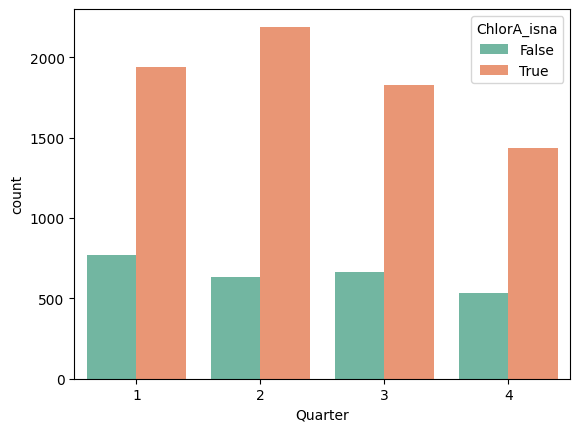

In [7]:
sns.countplot(x='Quarter', data=obj_bottle, hue='ChlorA_isna', palette='Set2')

Seems that there is not relationship. Now I want to check if is related with the location of the cast. Let's see what could be the most appropiate variables to see the location.

In [8]:
list_location_variables = ['Lat_Dec',
'Lat_Deg',
'Lat_Min',
'Lat_Hem',
'Lon_Dec',
'Lon_Deg',
'Lon_Min',
'Lon_Hem',]

obj_bottle[list_location_variables]

,Lat_Dec,Lat_Deg,Lat_Min,Lat_Hem,Lon_Dec,Lon_Deg,Lon_Min,Lon_Hem
0,25.316666,25,19.0,N,-114.433333,-114,26.0,W
1,22.741666,22,44.5,N,-111.950000,-111,57.0,W
2,37.616666,37,37.0,N,-123.125000,-123,7.5,W
3,23.758333,23,45.5,N,-114.291666,-114,17.5,W
4,33.216666,33,13.0,N,-121.500000,-121,30.0,W
...,...,...,...,...,...,...,...,...
9995,20.000000,20,0.0,N,-125.000000,-125,0.0,W
9996,32.675000,32,40.5,N,-117.858333,-117,51.5,W
9997,37.625000,37,37.5,N,-123.616666,-123,37.0,W
9998,30.900000,30,54.0,N,-122.183333,-122,11.0,W


Seems that `Lat_Dec` and `Lon_Dec` are the most appropiate variables, let's plot them and compare with our objective variable

In [9]:
# I want to see the non null value first in the plot
obj_bottle = obj_bottle.sort_values(by='ChlorA_isna', ascending=False)

<Axes: xlabel='Lon_Dec', ylabel='Lat_Dec'>

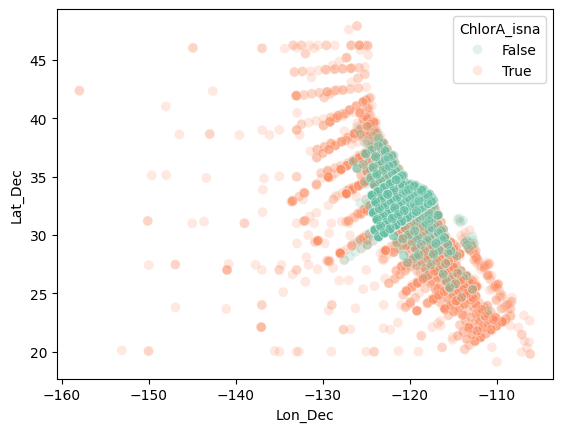

In [10]:
sns.scatterplot(x='Lon_Dec', y='Lat_Dec', hue='ChlorA_isna', data=obj_bottle, palette='Set2', alpha=0.2, s=50)

There is a clear relationship between the location and the null values! That white blank close to the center of the most common casts seems to be The Baja California Peninsula, lets try to plot it into a map.

In [11]:
def assign_color(category):
    if category:
        return 'grey'
    else:
        return 'red'

In [12]:
map_center = [obj_bottle['Lat_Dec'].mean(), obj_bottle['Lon_Dec'].mean()]
mymap = folium.Map(location=map_center, zoom_start=4)
for i in obj_bottle.index:
    folium.CircleMarker(
        location=[obj_bottle.loc[i, 'Lat_Dec'], obj_bottle.loc[i, 'Lon_Dec']],
        radius=1,
        color=assign_color(obj_bottle.loc[i, 'ChlorA_isna']),
        fill=True,
        fill_color=assign_color(obj_bottle.loc[i, 'ChlorA_isna']),
        popup=obj_bottle.loc[i, 'ChlorA_isna']
    ).add_to(mymap)

mymap.save('images/my_map.html')

Folium returns an HTML file containing the map; for convenience, we provide a static copy here. As we can see, that blank part in the previous plot was indeed the Baja California Peninsula. There seems to be a relationship between distance from LA and null values in the `ChlorA` variable. ![here](images/bottlemap.png)

This relationship probably means that there are extra cost related with the distance between the port and the cast place, also could be affecting other variables of the dataset which are actually important to predict the `ChlorA` levels. However the first conclusion that we can get from here is that all our results are bounded into the restricted area in which the ChlorA measures were taked, so if someone interesed in our results as a fishing company desires to used, must take this contrains into account. Before continue with the analysis of our objective variable, I feel important to know how other variables are related with that *distance from LA* variable. 

## Distances Analysis
in this subsection of EDA we explore more about the relationship between the distance and some missing values. You can Hide this part of the notebook.

In [13]:
# Join bottle and cast full datasets
obj_bottle = bottle.merge(cast, how='inner', on="Cst_Cnt")

In [14]:
# Distance from LA
la_coordinates = (34.052235, -118.243683) # (latidute, longitude)
obj_bottle["Lon_Dec_LA"] = obj_bottle["Lon_Dec"] - la_coordinates[1]
obj_bottle["Lat_Dec_LA"] = obj_bottle["Lat_Dec"] - la_coordinates[0]
# Now lets use Euclidean distance function to put the distance to LA in a single value
obj_bottle["Distance_LA"] = ((obj_bottle.Lon_Dec_LA**2) + (obj_bottle.Lat_Dec_LA**2))**0.5
# Which variables have null values?
hasnulls = obj_bottle.isna().astype(int).rename(columns={'Distance_LA': 'Distance_LA_notna'}).sum()
hasnulls_columns = hasnulls[hasnulls>0].index.tolist()
null_obj_bottle = obj_bottle.notna().astype(int).rename(columns={'Distance_LA': 'Distance_LA_notna'})[hasnulls_columns]
# Comparison between presence of null values and Distance to LA
obj_bottle_notna = pd.concat([null_obj_bottle,
                            obj_bottle["Distance_LA"]], axis=1)

In [15]:
corr_1 = obj_bottle_notna.corr().Distance_LA.sort_values(ascending=False).abs()

In [16]:
corr_1.sort_values(ascending=False).head(10)

Distance_LA    1.000000
Distance       0.480187
IntChl         0.347637
Order_Occ      0.327403
Data_Or        0.301121
R_NO3          0.297507
NO3uM          0.297507
NO3q           0.296200
R_NO2          0.281016
NO2uM          0.281016
Name: Distance_LA, dtype: float64

Oh! There is a `Distance` variable that we have ignored! Let's see the same relation using that variable

In [17]:
# Null values in cast.Distance
cast.Distance.notna().sum() / cast.shape[0]

np.float64(0.5730147657249157)

However, `Distance` has a lot of null values. Lets try to use the cast with less distance and then we recalculate all the distances based on that base value. Finally we will compare that with LA Distance. 

In [18]:
distance_origin = tuple(map(tuple, np.array(cast[cast.Distance.abs() == cast.Distance.abs().min()][['Lat_Dec', 'Lon_Dec']])))[0]

In [19]:
obj_bottle["Lon_Dec_OR"] = obj_bottle["Lon_Dec"] - distance_origin[1]
obj_bottle["Lat_Dec_OR"] = obj_bottle["Lat_Dec"] - distance_origin[0]
obj_bottle["Distance_OR"] = ((obj_bottle.Lon_Dec_OR**2) + (obj_bottle.Lat_Dec_OR**2))**0.5
# Which variables have null values?
hasnulls = obj_bottle.isna().astype(int).rename(columns={'Distance_OR': 'Distance_OR_notna'}).sum()
hasnulls_columns = hasnulls[hasnulls>0].index.tolist()
null_obj_bottle = obj_bottle.notna().astype(int).rename(columns={'Distance_OR': 'Distance_OR_notna'})[hasnulls_columns]
obj_bottle_notna = pd.concat([null_obj_bottle,
                            obj_bottle["Distance_OR"]], axis=1)

In [20]:
corr_2 = obj_bottle_notna.corr().Distance_OR.sort_values(ascending=False).abs()

In [21]:
corr_2.sort_values(ascending=False).head(10)

Distance_OR    1.000000
Distance       0.396566
IntChl         0.313408
Order_Occ      0.291002
Data_Or        0.272852
R_NO3          0.267558
NO3uM          0.267558
NO3q           0.266382
Barometer      0.250778
Dry_T          0.250530
Name: Distance_OR, dtype: float64

Interesting, there seems to be more correlation between LA position and the null values than the origin position we found based on the `Distance` Variable. However the trend is the same in both cases. Let's plot some of those strong relations variables!

In [22]:
def scatter_plot_distance(df, variable):
    df[f"{variable}_isna"] = df[variable].isna()
    # Plot the non null values first
    df = df.sort_values(by=f"{variable}_isna", ascending=False)
    sns.scatterplot(x='Lon_Dec', y='Lat_Dec', hue=f"{variable}_isna", data=df, palette='Set2', alpha=0.2, s=50)

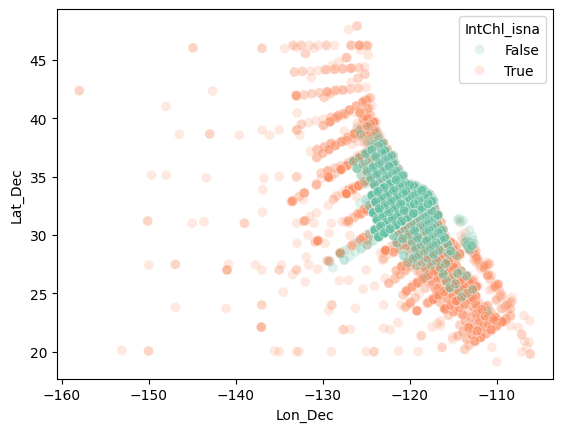

In [23]:
scatter_plot_distance(obj_bottle, 'IntChl')

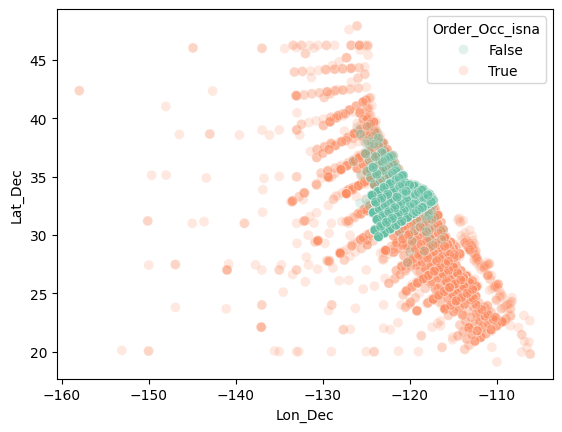

In [24]:
scatter_plot_distance(obj_bottle, 'Order_Occ')

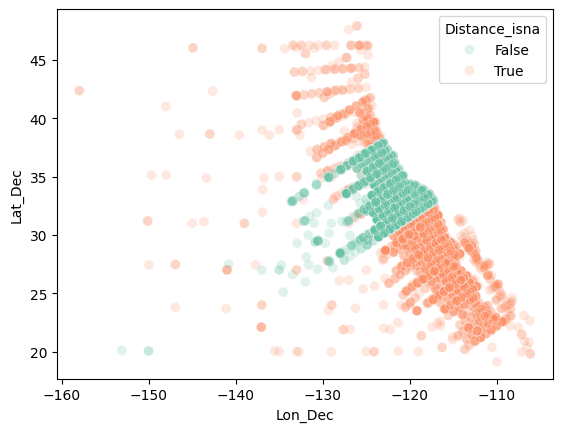

In [25]:
scatter_plot_distance(obj_bottle, 'Distance')

`IntChl`, `Order_Occ` and `Distance` follow a very simmilar pattern

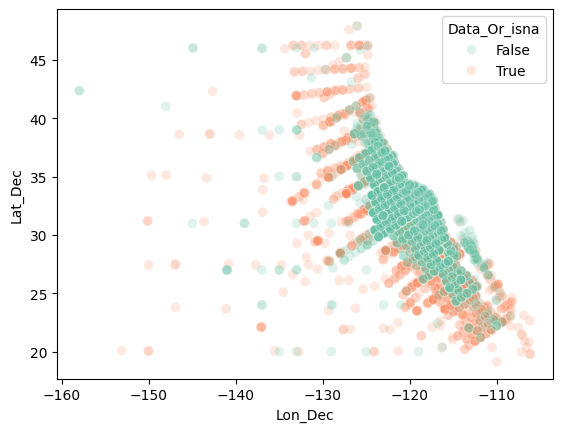

In [26]:
scatter_plot_distance(obj_bottle, 'Data_Or')

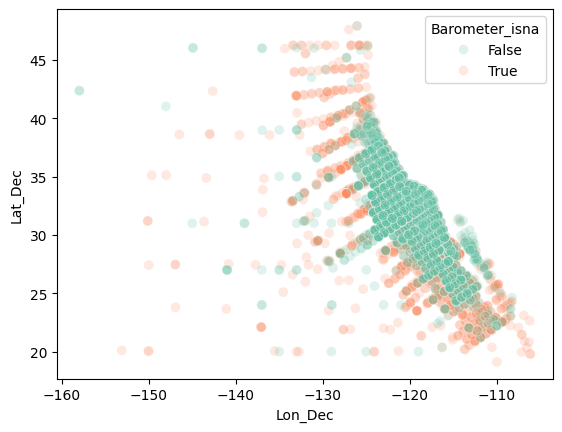

In [27]:
scatter_plot_distance(obj_bottle, 'Barometer')

`Data_Or` and `Barometer` follow a very simmilar pattern too. We are going to see just an aditional relationship which is the time in which the cast were done.

In [28]:
obj_bottle.corr(numeric_only=True)['Year']['Distance_LA']

np.float64(-0.35738083373267115)

Interesting, as the years go by, the distance to LA becomes shorter. Lets group years into decades so we can appreciate better any existent pattern

In [29]:
def years_into_decades(value):
    year_string = str(value)
    return f"{year_string[-2]}0" 

In [30]:
obj_bottle['decade'] = obj_bottle.Year.apply(years_into_decades)

<Axes: xlabel='Lon_Dec', ylabel='Lat_Dec'>

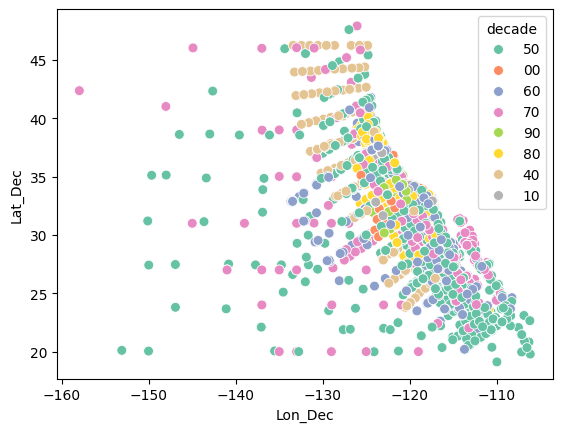

In [31]:
sns.scatterplot(x='Lon_Dec', y='Lat_Dec', hue="decade", data=obj_bottle, palette='Set2', s=50)

The output is not clear at all, lets try to see patterns in each decade

In [32]:
obj_bottle["ChlorA_isna"] = obj_bottle["ChlorA"].isna()

In [33]:
obj_bottle['forties'] = obj_bottle['decade'] == '40'

<Axes: xlabel='Lon_Dec', ylabel='Lat_Dec'>

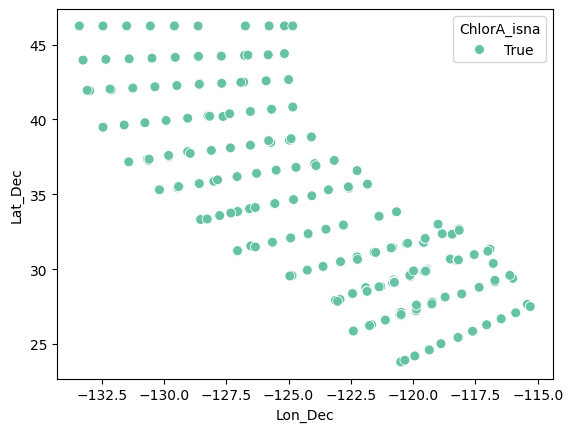

In [34]:
sns.scatterplot(x='Lon_Dec', y='Lat_Dec',  hue="ChlorA_isna",  data=obj_bottle[obj_bottle.forties], palette='Set2', s=50)

<Axes: xlabel='Lon_Dec', ylabel='Lat_Dec'>

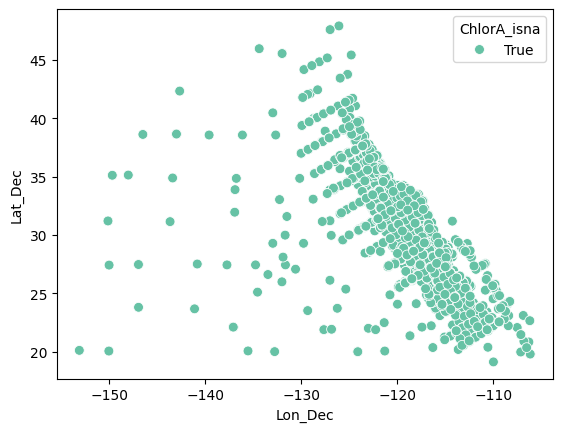

In [35]:
obj_bottle['fifties'] = obj_bottle['decade'] == '50'
sns.scatterplot(x='Lon_Dec', y='Lat_Dec',  hue="ChlorA_isna", data=obj_bottle[obj_bottle.fifties], palette='Set2', s=50)

<Axes: xlabel='Lon_Dec', ylabel='Lat_Dec'>

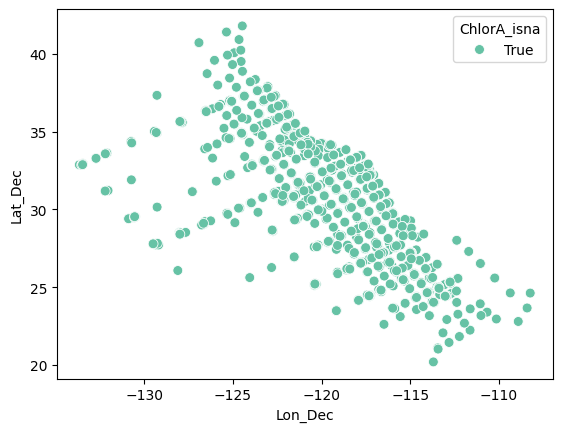

In [36]:
obj_bottle['sixties'] = obj_bottle['decade'] == '60'
sns.scatterplot(x='Lon_Dec', y='Lat_Dec',  hue="ChlorA_isna", data=obj_bottle[obj_bottle.sixties], palette='Set2', s=50)

<Axes: xlabel='Lon_Dec', ylabel='Lat_Dec'>

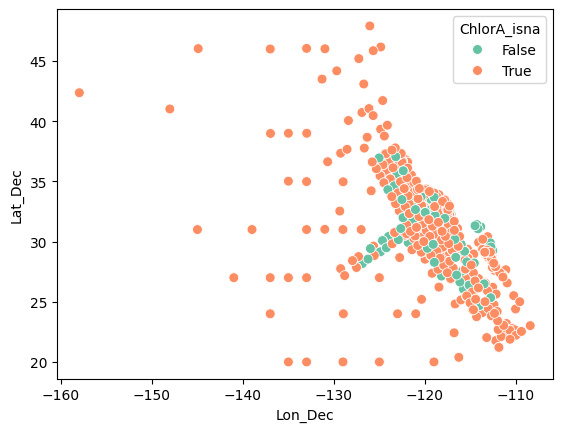

In [37]:
obj_bottle['seventies'] = obj_bottle['decade'] == '70'
sns.scatterplot(x='Lon_Dec', y='Lat_Dec',  hue="ChlorA_isna",  data=obj_bottle[obj_bottle.seventies], palette='Set2', s=50)

<Axes: xlabel='Lon_Dec', ylabel='Lat_Dec'>

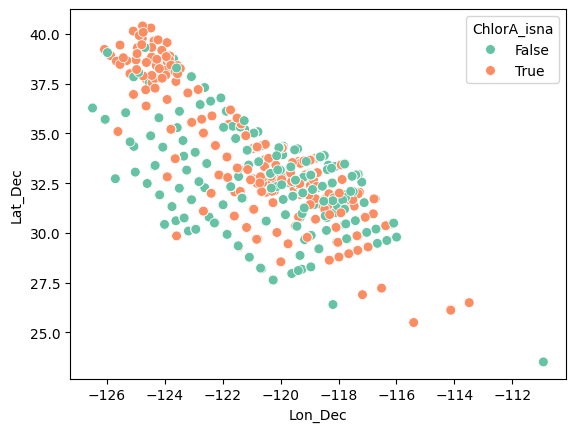

In [38]:
obj_bottle['eighties'] = obj_bottle['decade'] == '80'
sns.scatterplot(x='Lon_Dec', y='Lat_Dec',  hue="ChlorA_isna",  data=obj_bottle[obj_bottle.eighties], palette='Set2', s=50)

<Axes: xlabel='Lon_Dec', ylabel='Lat_Dec'>

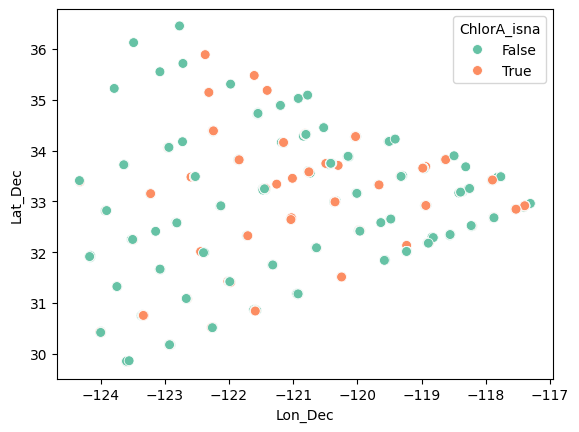

In [39]:
obj_bottle['nineties'] = obj_bottle['decade'] == '90'
sns.scatterplot(x='Lon_Dec', y='Lat_Dec',  hue="ChlorA_isna",  data=obj_bottle[obj_bottle.nineties], palette='Set2', s=50)

<Axes: xlabel='Lon_Dec', ylabel='Lat_Dec'>

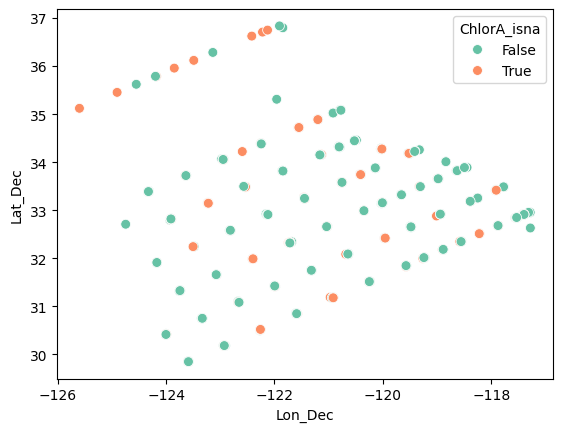

In [40]:
obj_bottle['twothousands'] = obj_bottle['decade'] == '00'
sns.scatterplot(x='Lon_Dec', y='Lat_Dec',  hue="ChlorA_isna",  data=obj_bottle[obj_bottle.twothousands], palette='Set2', s=50)

<Axes: xlabel='Lon_Dec', ylabel='Lat_Dec'>

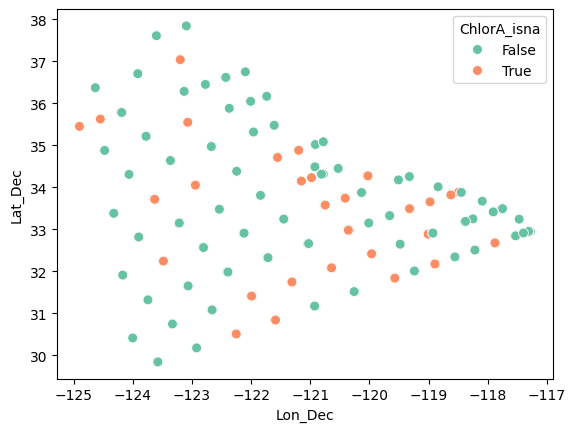

In [41]:
obj_bottle['tens'] = obj_bottle['decade'] == '10'
sns.scatterplot(x='Lon_Dec', y='Lat_Dec',  hue="ChlorA_isna",  data=obj_bottle[obj_bottle.tens], palette='Set2', s=50)

1. There were at least three different methodologies through the years for take the samples with the cast.
2. Our objective variable was not taken until the seventies and became common from the eighties to now.

We are going to stop the distance analysis here and we are going to focus on the analysis of our objective variable.

## Explore the potential predictors
In this section we are going to explore some of the potential predictors of our objective variable `ChlorA`

In [42]:
bottle_chlora = bottle[bottle.ChlorA.notna()]

In [43]:
obj_bottle = bottle_chlora.merge(cast, how='inner', on="Cst_Cnt")

In [44]:
correlations = obj_bottle.corr(numeric_only = True).abs()['ChlorA'].sort_values(ascending=False)

In [45]:
strong_correlations = correlations[(correlations > 0.3) & (correlations < 1)].iloc[1:].index
correlations[(correlations > 0.3) & (correlations < 1)].iloc[1:]

C14As2     0.783111
C14As1     0.729736
MeanAs     0.720795
R_PHAEO    0.720127
Phaeop     0.720092
Phaqua     0.647863
Chlqua     0.647863
IntChl     0.617868
IntC14     0.593631
ForelU     0.500728
SThtaq     0.367513
DIC1       0.345524
S_qual     0.333821
Secchi     0.308971
Name: ChlorA, dtype: float64

In [46]:
# collinearity analysis
obj_bottle[strong_correlations].corr()

,C14As2,C14As1,MeanAs,R_PHAEO,Phaeop,Phaqua,Chlqua,IntChl,IntC14,ForelU,SThtaq,DIC1,S_qual,Secchi
C14As2,1.000000,0.988038,0.996672,0.567264,0.567303,NaN,NaN,0.512796,0.652837,0.483106,NaN,NaN,NaN,-0.443992
C14As1,0.988038,1.000000,0.997281,0.515105,0.515094,NaN,NaN,0.462635,0.620347,0.461072,NaN,NaN,NaN,-0.427320
MeanAs,0.996672,0.997281,1.000000,0.524748,0.524761,NaN,NaN,0.496320,0.589138,0.450517,0.122787,NaN,0.017897,-0.403680
R_PHAEO,0.567264,0.515105,0.524748,1.000000,0.999996,-0.131685,-0.131685,0.556228,0.566543,0.538664,0.356613,-0.360040,0.374040,-0.360423
Phaeop,0.567303,0.515094,0.524761,0.999996,1.000000,-0.148288,-0.148288,0.556197,0.566206,0.538664,0.356791,-0.359540,0.374118,-0.360460
Phaqua,NaN,NaN,NaN,-0.131685,-0.148288,1.000000,1.000000,0.246448,NaN,NaN,NaN,NaN,NaN,NaN
Chlqua,NaN,NaN,NaN,-0.131685,-0.148288,1.000000,1.000000,0.246448,NaN,NaN,NaN,NaN,NaN,NaN
IntChl,0.512796,0.462635,0.496320,0.556228,0.556197,0.246448,0.246448,1.000000,0.753789,0.530597,0.189019,0.023098,0.155682,-0.409759
IntC14,0.652837,0.620347,0.589138,0.566543,0.566206,NaN,NaN,0.753789,1.000000,0.668320,-0.062405,0.578076,-0.193754,-0.530998
ForelU,0.483106,0.461072,0.450517,0.538664,0.538664,NaN,NaN,0.530597,0.668320,1.000000,NaN,NaN,NaN,-0.729603


# Model Training
In this section, we will train our predictive model using polynomial regression. We will employ grid search and cross-validation techniques to explore different parameter values, such as varying the polynomial degree, and utilize regularization methods including ridge, lasso, or elastic net. We will also assess bias and variance through learning curves to ensure the model's robustness.

In [68]:
bottle = pd.read_csv("datasets/calcofi/bottle.csv")
cast = pd.read_csv("datasets/calcofi/cast.csv")

/tmp/ipykernel_11070/4096869757.py:1: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  bottle = pd.read_csv("datasets/calcofi/bottle.csv")
/tmp/ipykernel_11070/4096869757.py:2: DtypeWarning: Columns (40,41,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  cast = pd.read_csv("datasets/calcofi/cast.csv")


In [69]:
numeric_bottle_columns = bottle.sample(100).dtypes[~(bottle.sample(100).dtypes == object)].index

In [70]:
bottle = bottle[numeric_bottle_columns]

In [71]:
cast["int_date"] = pd.to_datetime(cast['Date']).astype(int)
numeric_cast_columns = cast.dtypes[cast.dtypes != object].index

In [72]:
cast = cast[numeric_cast_columns]

In [73]:
# Merge the datasets in one
full_dataset = bottle.merge(cast, how='inner', on="Cst_Cnt")

## Split training and test set